<a href="https://colab.research.google.com/github/Rwolste/DS2002-Asignments/blob/main/project_DS2002.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Extracted remote weather from API.
Loaded local weather data.

 Remote Data Summary
Rows: 1 | Columns: 6

 Local Data Summary
Rows: 389 | Columns: 6
Merged datasets.

 Merged Data Summary
Rows: 390 | Columns: 6
Trend analysis complete.

 Trend Data Summary
Rows: 2 | Columns: 2
Exported to CSV and JSON: merged_weather
Exported to CSV and JSON: weather_trends
Saved to SQL: weather_data
Saved to SQL: temperature_trends


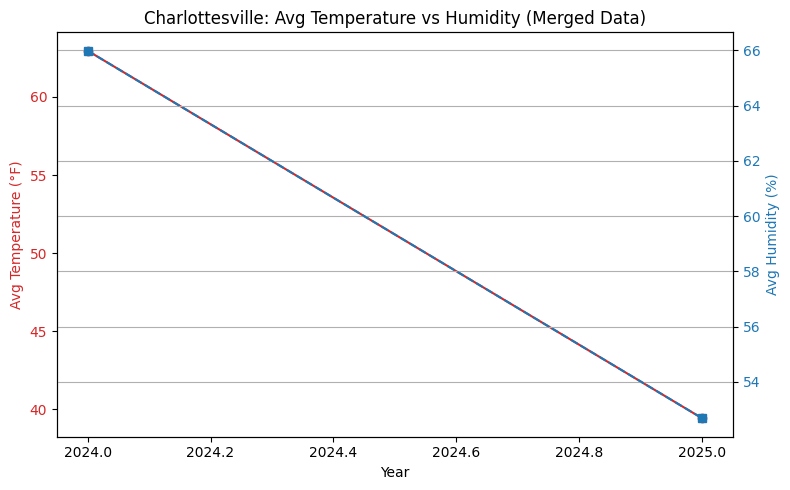

In [14]:
import pandas as pd
import requests
import sqlite3
from sqlalchemy import create_engine
from datetime import datetime

# --- Config ---
API_KEY = ''  # Replace with your actual key
LOCAL_FILE_PATH = '22911, Charlottesville, V... 2024-03-01 to 2025-03-24.csv'
SQLITE_DB = 'weather_patterns.db'
REMOTE_API_URL = f"http://api.weatherstack.com/current?access_key={API_KEY}&query=Charlottesville"

# --- Extract ---
def extract_remote_weather():
    try:
        response = requests.get(REMOTE_API_URL)
        data = response.json()
        if 'current' in data:
            df = pd.DataFrame([{
                'datetime': pd.Timestamp.now().strftime('%Y-%m-%d'),
                'temp': data['current']['temperature'],
                'humidity': data['current']['humidity'],
                'windspeed': data['current']['wind_speed'],
                'conditions': data['current']['weather_descriptions'][0],
                'source': 'Weatherstack API'
            }])
            print("Extracted remote weather from API.")
            return df
        else:
            print(f"API error: {data}")
            return None
    except Exception as e:
        print(f"Error extracting from Weatherstack: {e}")
        return None

def extract_local_csv(path):
    try:
        df = pd.read_csv(path)
        df = df[['datetime', 'temp', 'humidity', 'windspeed', 'conditions']]
        df['source'] = 'Local CSV'
        print("Loaded local weather data.")
        return df
    except Exception as e:
        print(f"Error loading local file: {e}")
        return None

# --- Transform ---
def merge_datasets(remote_df, local_df):
    try:
        combined = pd.concat([remote_df, local_df], ignore_index=True)
        combined['datetime'] = pd.to_datetime(combined['datetime'])
        print("Merged datasets.")
        return combined
    except Exception as e:
        print(f" Error merging data: {e}")
        return None

def analyze_trends(df):
    try:
        df['year'] = df['datetime'].dt.year
        trend = df.groupby('year')['temp'].mean().reset_index(name='avg_temp')
        print("Trend analysis complete.")
        return trend
    except Exception as e:
        print(f"Error analyzing trends: {e}")
        return None

# --- Save/Load ---
def save_to_sql(df, table_name):
    try:
        engine = create_engine(f'sqlite:///{SQLITE_DB}')
        df.to_sql(table_name, con=engine, if_exists='replace', index=False)
        print(f"Saved to SQL: {table_name}")
    except Exception as e:
        print(f"SQL save failed: {e}")

def export_files(df, base_name):
    try:
        df.to_csv(f'{base_name}.csv', index=False)
        df.to_json(f'{base_name}.json', orient='records', lines=True)
        print(f"Exported to CSV and JSON: {base_name}")
    except Exception as e:
        print(f"Export failed: {e}")

def summarize(df, label):
    print(f"\n {label} Summary")
    print(f"Rows: {len(df)} | Columns: {len(df.columns)}")

# --- Main Flow ---
def main():
    remote_df = extract_remote_weather()
    local_df = extract_local_csv(LOCAL_FILE_PATH)

    if remote_df is None or local_df is None:
        print("Extraction failed. Exiting.")
        return

    summarize(remote_df, "Remote Data")
    summarize(local_df, "Local Data")

    merged_df = merge_datasets(remote_df, local_df)
    summarize(merged_df, "Merged Data")

    trend_df = analyze_trends(merged_df)
    summarize(trend_df, "Trend Data")

    export_files(merged_df, 'merged_weather')
    export_files(trend_df, 'weather_trends')

    save_to_sql(merged_df, 'weather_data')
    save_to_sql(trend_df, 'temperature_trends')

    plot_temp_vs_humidity(merged_df)

if __name__ == "__main__":
    main()



import matplotlib.pyplot as plt

def plot_temp_vs_humidity(df):
    try:
        df['year'] = df['datetime'].dt.year
        grouped = df.groupby('year')[['temp', 'humidity']].mean().reset_index()

        fig, ax1 = plt.subplots(figsize=(8, 5))

        color = 'tab:red'
        ax1.set_xlabel('Year')
        ax1.set_ylabel('Avg Temperature (°F)', color=color)
        ax1.plot(grouped['year'], grouped['temp'], marker='o', color=color)
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('Avg Humidity (%)', color=color)
        ax2.plot(grouped['year'], grouped['humidity'], marker='s', linestyle='--', color=color)
        ax2.tick_params(axis='y', labelcolor=color)

        plt.title("Charlottesville: Avg Temperature vs Humidity (Merged Data)")
        fig.tight_layout()
        plt.grid(True)
        plt.show()

    except Exception as e:
        print(f"Plotting failed: {e}")
